In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
pd.options.mode.chained_assignment = None
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import pickle

In [44]:
#load cleaned train and validation dataset
df = pd.read_csv('TrainAndValidCleaned.csv', parse_dates=["saledate"], low_memory=False)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 31 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   SalesID                              412698 non-null  int64         
 1   SalePrice                            412698 non-null  float64       
 2   MachineID                            412698 non-null  int64         
 3   ModelID                              412698 non-null  int64         
 4   datasource                           412698 non-null  int64         
 5   auctioneerID                         412698 non-null  float64       
 6   YearMade                             412698 non-null  float64       
 7   MachineHoursCurrentMeter             412698 non-null  float64       
 8   saledate                             412698 non-null  datetime64[ns]
 9   fiModelDesc                          412698 non-null  int64         
 

In [46]:
# First let's drop some columns that will not bring us any value to the model.
df = df.drop(['auctioneerID_is_missing', 'YearMade_is_missing', 'MachineHoursCurrentMeter_is_missing'], axis=1)
# In addition we drop saleedata that is in datetime format. This causes trouble during model fitting. We have this information in SaleX columns 
df = df.drop(['saledate'], axis=1)

In [47]:
# X are our independent variables (we will predict dependent variable y based on x). 
X = df.drop(["SalePrice"], axis=1)
# And the dependent variable
y = df["SalePrice"]

In [48]:
train, valid = train_test_split(df, test_size=0.2)
X_train, y_train = train.drop(["SalePrice"], axis=1), train['SalePrice']
X_valid, y_valid = valid.drop(["SalePrice"], axis=1), valid['SalePrice']

In [49]:
# n_estimators, default=100. The number of trees in the forest.
# Popular integer random seeds are 0 and 42
model = RandomForestRegressor(n_estimators=30, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=30, random_state=42)

### Scoring

Unlike classification, one cannot use classification accuracy to evaluate the predictions made by a regression model. We cannot calculate accuracy for a regression model. There are three error metrics that are commonly used for evaluating and reporting the performance of a regression model; they are:

- Mean Squared Error (MSE). # This has the effect of “punishing” models more for larger errors when MSE is used as a loss function. It also has the effect of “punishing” models by inflating the average error score when used as a metric.
- RMSLE
- R2 (r2 defined as the proportion of the variance in the dependent variable that is predictable from the independent variable(s).Another definition is “(total variance explained by model) / total variance.” So if it is 100%, the two variables are perfectly correlated, i.e., with no variance at all. A low value would show a low level of correlation, meaning a regression model that is not valid, but not in all cases.)

In [50]:
y_true = y_valid
y_pred = model.predict(X_valid)

print('MSE:', sklearn.metrics.mean_squared_error(y_true, y_pred, squared=True))
print('RMSLE:', np.sqrt(mean_squared_log_error(y_true,y_pred)))
print('R2 score:', r2_score(y_true,y_pred))

MSE: 53159818.05036605
RMSLE: 0.22014493980163943
R2 score: 0.9017261589712638


In [51]:
# Just for curiosity we can check what is the performance on training set
y_true = y_train
y_pred = model.predict(X_train)

print('MSE:', sklearn.metrics.mean_squared_error(y_true, y_pred, squared=True))
print('RMSLE:', np.sqrt(mean_squared_log_error(y_true,y_pred)))
print('R2 score:', r2_score(y_true,y_pred))

MSE: 7915051.87132885
RMSLE: 0.09199601140789063
R2 score: 0.9851830396242004


### Importance of features

First let's check if some features are correlated with each other. These which are correlated should be dropped because they dont breing any value to the model

In [ ]:
corr = df.corr()
sns.set(rc={'figure.figsize':(20,15)})
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [53]:
# We can easily drop: 'ProductGroupDesc', 'fiModelDesc'

In [59]:
features_to_drop = ['ProductGroupDesc', 'fiModelDesc', 'SalePrice'] # in addition need to drop the dependent variable
# Let's see how feature removal impacts the model performance
X_train, y_train = train.drop(features_to_drop, axis=1), train['SalePrice']
X_valid, y_valid = valid.drop(features_to_drop, axis=1), valid['SalePrice']

# We train once again
model = RandomForestRegressor(n_estimators=30, random_state=42)
model.fit(X_train, y_train)

# And measure the performance
y_true = y_valid
y_pred = model.predict(X_valid)

print('MSE:', sklearn.metrics.mean_squared_error(y_true, y_pred, squared=True))
print('RMSLE:', np.sqrt(mean_squared_log_error(y_true,y_pred)))
print('R2 score:', r2_score(y_true,y_pred))

MSE: 53307262.06102773
RMSLE: 0.22044947763065745
R2 score: 0.9014535867579677


R2 score was decreased only by 0.0003 so it is reasonable to drop these columns.
Now let's see how important are model features

In [60]:
# Helper function for plotting feature importance
def plot_features(columns, importances, n=30):
    df = (pd.DataFrame({"features":columns,
                        "features_importances": importances})
          .sort_values("features_importances",ascending=False)
          .reset_index(drop=True))
    
    # Plot the dataframe we created
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["features_importances"][:n])
    ax.set_ylabel("Features")
    ax.set_xlabel("Features Importance")
    ax.invert_yaxis()

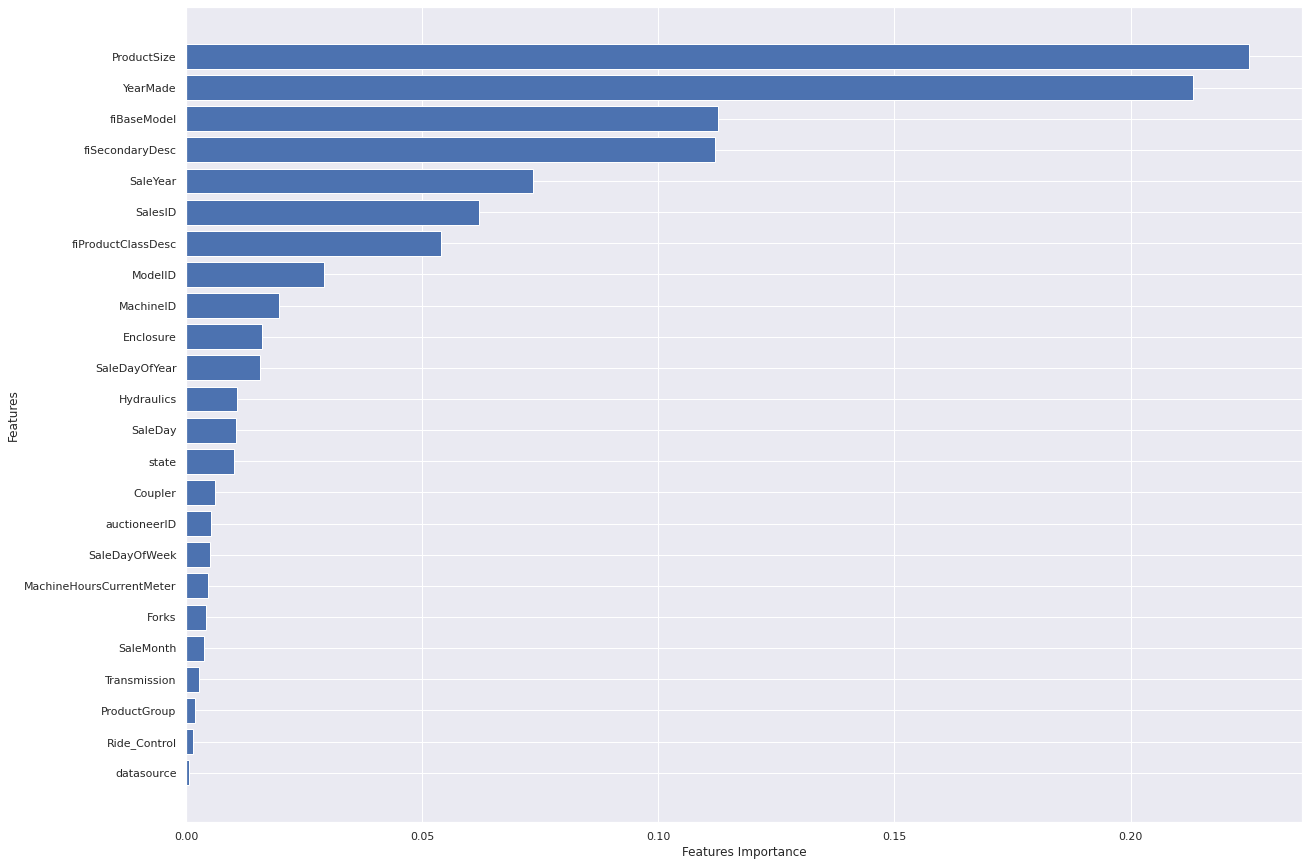

In [61]:
plot_features(X_train.columns, model.feature_importances_,30)

In [65]:
# Let's make an experiment now. Let's drop some less important features and see the results. 
# Despite 'SalesID' is one of the most important feature it is hard to figure out this value for a potential user. Therefore it might be worthwile to drop
important_cols = ['ProductSize', 'YearMade', 'fiBaseModel', 'fiSecondaryDesc', 'SaleYear', 'fiProductClassDesc']
X_train, y_train = train[important_cols], train['SalePrice']
X_valid, y_valid = valid[important_cols], valid['SalePrice']

In [66]:
# We train once again
model = RandomForestRegressor(n_estimators=30, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=30, random_state=42)

In [67]:
# And measure the performance
y_true = y_valid
y_pred = model.predict(X_valid)

print('MSE:', sklearn.metrics.mean_squared_error(y_true, y_pred, squared=True))
print('RMSLE:', np.sqrt(mean_squared_log_error(y_true,y_pred)))
print('R2 score:', r2_score(y_true,y_pred))

MSE: 64018728.206440926
RMSLE: 0.23763376129279237
R2 score: 0.8816518462749268


The performance is not much worse and it simplifies further use of the 
So the final model is based on params: 'ProductSize', 'YearMade', 'fiBaseModel', 'fiSecondaryDesc', 'SaleYear', 'fiProductClassDesc'

In [97]:
# Let's dump the model as a pickle pile
a_file = open("model.pkl", "wb")
pickle.dump(model, a_file)
a_file.close()

### Make predictions on user data

In [93]:
# Let's define some dummy data that a user can type
ProductSize = 0
YearMade = 1990
fiBaseModel = 100
fiSecondaryDesc = 0
SaleYear = 2000
fiProductClassDesc = 30

d = {
    'ProductSize':ProductSize, 
    'YearMade':YearMade, 
    'fiBaseModel':fiBaseModel, 
    'fiSecondaryDesc':fiSecondaryDesc, 
    'SaleYear':SaleYear, 
    'fiProductClassDesc':fiProductClassDesc
}

df_test = pd.DataFrame(d, index=[0])
df_test

,ProductSize,YearMade,fiBaseModel,fiSecondaryDesc,SaleYear,fiProductClassDesc
0,0,1990,100,0,2000,30


In [94]:
# The following is the price for given parameters
y_test = model.predict(df_test)
y_test[0]

16991.54761904762

In [ ]:
# Next step is to get dictionary of categories so API can work